### Project Imports

In [2]:
from importlib import reload

In [319]:
import os.path
import numpy as np
import pandas as pd
import torch
import pickle

import minimal_version.parser_handler
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks/
from minimal_version.preprocess_msa import Preprocessor, weight_sequences
from minimal_version.msa import MSA
from minimal_version.utils import Capturing, store_to_pkl, store_to_fasta, load_from_pkl

from minimal_version.train import setup_train, Train
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks/

/Users/dahala/GitHub/VAE-enzymes/vae_notebooks
/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks


### Project Configuration
Configure your project using the configuration file. Use the modelConfig template as a guide. 

A value of -1 indicates that the default value will be used. 

Please note that every time the RunSetup class is executed, the current version of the configuration file will be copied to your specified directory, allowing you to review all set parameters at any time.  

Run just one of the two cell below (working with/without Pfam)

In [402]:
CONFIGURATION_FILE = "pfamGT1Small_hmm.json"
run = minimal_version.parser_handler.RunSetup(CONFIGURATION_FILE)
print(f" Working with {CONFIGURATION_FILE} configuration file!")
PFAM_INPUT = False

Configuration file stored in ../results/pfam201_hmm/config/2024-08-20_23-53.json
 Working with pfamGT1Small_hmm.json configuration file!


In [124]:
CONFIGURATION_FILE = "pfamGT1Small.json"
run = minimal_version.parser_handler.RunSetup(CONFIGURATION_FILE)
print(f" Working with {CONFIGURATION_FILE} configuration file!")
PFAM_INPUT = True

Configuration file stored in ../results/pfam201/config/2024-08-19_16-04.json
 Working with pfamGT1Small.json configuration file!


In [317]:
import sys, importlib
importlib.reload(sys.modules['minimal_version.preprocess_msa'])
from minimal_version.preprocess_msa import Preprocessor

### MSA preprocessing
Prepare your MSA for training by filtering it according to the queries specified in the configuration file. This includes both the query sequences and any fixed sequences defined.

In [318]:
"""
Preprocess MSA and prepare it for VAE model training
"""

# logging
msa_log = open(os.path.join(run.logs, 'msa_log.txt'), "w")

# MSA loading
if PFAM_INPUT:
    msa = MSA.load_pfam(run.dataset)
else:
    msa = MSA.load_msa(run.dataset)
MSA.amino_acid_dict(run.pickles)
msg = f"MSA in {run.dataset} loaded\n" \
      f"number of sequences: {len(list(msa.keys()))}"
print(msg)
msa_log.write(msg + f'\n{"="*80}\n')

# MSA preprocessing
preprocessor = Preprocessor(run)
with Capturing() as output:
    msa, msa_keys = preprocessor.trim_msa(msa)
msa_log.write(" MSA Preprocessing \n" + "\n".join(output) + f'\n{"="*80}\n')
assert (msa.shape[0] == len(msa_keys))
trim_file_path = os.path.join(run.msa, "trimmed_msa.fasta")
msg = f"Trimmed MSA has {msa.shape[0]} sequences and the width is {msa.shape[1]}\n" \
      f"Trimmed MSA is stored at {trim_file_path}"
print(msg)
msa_log.write(msg + f'\n{"="*80}\n')
msa_num_dict_shuffled = {k: seq for k, seq in zip(msa_keys, msa)}  # transform to dictionary, have keys together
# but secure that query and fixed sequences are at the beginning 
msa_num_dict = {k: msa_num_dict_shuffled[k] for k in preprocessor.keep_keys}
msa_num_dict.update({k: msa_num_dict_shuffled[k] for k in msa_num_dict_shuffled if k not in preprocessor.keep_keys})

trimmed_msa = MSA.number_to_amino(msa_num_dict)
store_to_fasta(trimmed_msa, trim_file_path)
store_to_pkl({run.query: trimmed_msa[run.query]}, os.path.join(run.pickles, "reference_seq.pkl"))

# Filtering or weighting
with Capturing() as output:
    if run.clustering:  # MSA filtering
        print(f"MSA {run.identity}% identity filtering step")
        msa_num_dict = preprocessor.identity_filtering(msa_num_dict)
        msa, training_alg = preprocessor.get_keys_file_and_np_sequences(msa_num_dict)  # Overlap one treemmer
        seq_weight = np.ones(msa.shape[0])  # we just provide uniform weights for all sequences
    else:  # otherwise the weighting mechanism will be applied
        msa, training_alg = preprocessor.get_keys_file_and_np_sequences(msa_num_dict)  # Overlap one treemmer
        seq_weight = weight_sequences(msa)
msa_log.write("\n".join(output))
train_msa_file_path = os.path.join(run.msa, "training_msa.fasta")
training_alg = MSA.number_to_amino(training_alg)
store_to_fasta(training_alg, train_msa_file_path)
msg = f"Training MSA has {msa.shape[0]} sequences and the width is {msa.shape[1]}\n" \
      f"Training MSA is stored at {train_msa_file_path}"
print(msg)
msa_log.write(msg + f'\n{"=" * 80}\n')

store_to_pkl(seq_weight, os.path.join(run.pickles, "seq_weight.pkl"))
store_to_pkl(training_alg, os.path.join(run.pickles, "training_alignment.pkl"))

# MSA one-hot encoding
binary = MSA.number_to_binary(msa)
store_to_pkl(binary, os.path.join(run.pickles, "seq_msa_binary.pkl"))
msa_log.close()


MSA in ../datasets/PFAM_hmmalign_fix.faa loaded
number of sequences: 90320
Trimmed MSA has 60873 sequences and the width is 427
Trimmed MSA is stored at ../results/pfam201_hmm/msa/trimmed_msa.fasta
Training MSA has 60873 sequences and the width is 427
Training MSA is stored at ../results/pfam201_hmm/msa/training_msa.fasta


#### Conditional labels
Before starting the training process, ensure that your labels are properly preprocessed if you intend to use them for **conditional training**. 

This involves converting your labels into a suitable format, such as one-hot or integer encoding (see and modify **custom_classifier** function). 

Additionally, specify the number of classes represented by your labels.

In [ ]:
# Specify number of classes
N_CLASSES = 3

def parse_conditional_labels_to_categories(file_name):
    """ Parse conditional label file """
    # Please specify your classification function to the bins, the interface of function must stay the same, example
    def custom_classifier(sol_val: float) -> torch.Tensor:
        if sol_val < run.solubility_threshold1:
            return torch.tensor([1,0,0])
        if sol_val <= run.solubility_threshold1:
            return torch.tensor([0,1,0])
        return torch.tensor([0,0,1])
    
    label_dict = {}
    with open(file_name, "r") as sol_data:
        for i, record in enumerate(sol_data):
            if i == 0:  # header
                continue
            accession, label_val = record.split("\t")
            if label_val is None or len(label_val) == '':
                print(f"Error while parsing labels, accession {accession} does not have labels")
                exit(1)
            label_dict[accession] = custom_classifier(float(label_val))
    return label_dict

""" In the case of conditional model please preprocess labels """
label_file_path = run.conditional_labels  # you can specify it in the configuration path or provide custom one 

# Now get labels from your file, simple txt or similar file with sequence accession\tlabel_value pair per line (modify function as needed)  
label_dict = parse_conditional_labels_to_categories(label_file_path)

labels_file_pkl = os.path.join(run.conditional_data, "conditional_labels_to_categories.pkl")
msa_keys = load_from_pkl(os.path.join(run.pickles, "keys_list.pkl"))

# get labels to the similar order as in msa (just in case, to enable using indexes in training method)
msa_key_label_order = {}
array_of_labels = torch.zeros(len(msa_keys), N_CLASSES)
for label_i, msa_key in enumerate(msa_keys):
    try:
        msa_key_label_order[msa_key] = label_dict[msa_key]
        array_of_labels[label_i] = label_dict[msa_key]
    except KeyError:
        print(f"{msa_key} is not in the label_dict, please provide labels for all sequences")
        exit(1)
        
# now store in both raw and text version
store_to_pkl(array_of_labels, labels_file_pkl)
with open(os.path.join(run.conditional_data, "msa_key_label_order.txt"), 'w') as txt_labels:
    for k, label_tensor in msa_key_label_order.items():
        txt_labels.write(f"{k} {label_tensor}\n")

### Training of the model
Select the models you would like to work with and prepare data for training and benchmarking if selected in configuration file. 

If you select a conditional model please see above cell and prepare labels for it.  

In [403]:
""" Configure model """
available_models = ["vae", "vae_conditional"]
model_selected = available_models[0]

""" Prepare data for training """
setup_train(run, model_selected)

 Leaving out 5% sequences from training for generative capacity evaluation (3043 sequences in total)


In [404]:
"""
Train VAE with a preprocessed MSA
:param conf_path: path to the configuration file of the project
:return:
"""
# logging
train_log = open(os.path.join(run.logs, 'train_log.txt'), "w")
model = Train(run)
with Capturing() as output_train:
    model.train()
train_log.write(" Training \n" + "\n".join(output_train) + f'\n{"=" * 80}\n')
train_log.close()

: 

In [309]:
""" Do I work with conditional model? """

load_from_pkl(os.path.join(run.model, "model_params.pkl"))['model']

'vae'

### Generative Capacity evaluation
If you wish to obtain estimates of your model's generative capacity, please set run_capacity_test to true in the configuration file before starting the training.

This test generates first and second order statistics of your model.

In [312]:
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks
from notebooks.minimal_version.benchmark import Benchmarker
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks/
run.weights = f'../results/pfam201/model/vae_fold_0_e999.model'
""" 
Benchmark model 
How well our model can regenarate sequences in various sets (positive, negative and training)
"""
N_SAMPLES = 500

Benchmarker(run, samples=N_SAMPLES).bench_dataset()


/Users/dahala/GitHub/VAE-enzymes/vae_notebooks
/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks
 Benchmark message : Creating the profile of MSA
 Benchmark message : Negative control 3043 samples generated...


KeyboardInterrupt: 

### Projection to the latent space
Project all points to the latent space and make custom selection of sequences

/Users/dahala/GitHub/VAE-enzymes/vae_notebooks
/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks


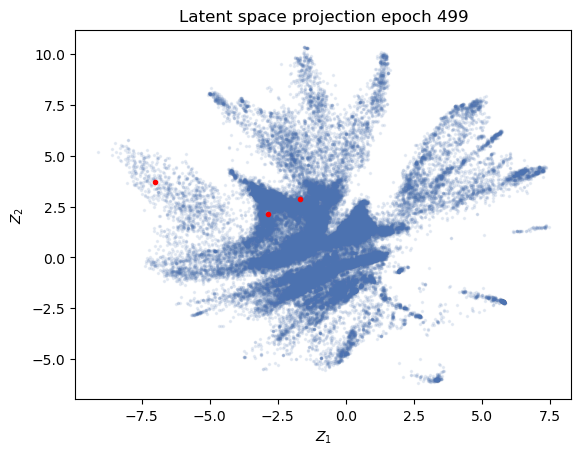

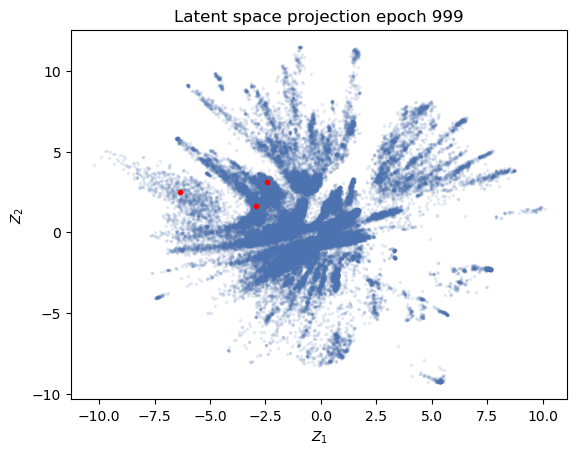

In [311]:
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks
from matplotlib import pyplot as plt
from notebooks.minimal_version.latent_space import LatentSpace
%cd /Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks/
for epoch in range(1,1000):
    if (epoch + 1) % 500 == 0:
        # Projection to the latent space
        # Show your queries
        run.weights = f'../results/pfam201_hmm/model/vae_fold_0_e{epoch}.model'
        latent_space = LatentSpace(run)
        msa_embeddings = latent_space.msa_embeddings["mus"]


        query_coords = latent_space.key_to_embedding(run.fixed_sequences)

        custom_sequences = []  # give keys to MSA and embed them to the latent space


        fig_lat, ax = plt.subplots(1, 1)

        ax.plot(msa_embeddings[:, 0], msa_embeddings[:, 1], '.', alpha=0.1, markersize=3, )
        ax.plot(query_coords[0::2], query_coords[1::2], '.', color='red')

        # Project 
        for seq_id, seq_mu in enumerate(custom_sequences):
            ax.plot(seq_mu[0], seq_mu[1], '.', color='black', alpha=1, markersize=5,
                    label='({})'.format(seq_id))
            
            ax.annotate(str(seq_id), (seq_mu[0], seq_mu[1]))
        ax.set_xlabel("$Z_1$")
        ax.set_ylabel("$Z_2$")
        ax.set_title(f"Latent space projection epoch {epoch}")
        fig_lat.savefig(os.path.join(run.results, f"latent_space_e{epoch}.png"))

### Generate ancestors
Using straight evolution protocol  

In [313]:
from notebooks.minimal_version.evolution_protocols.straight_evolution import StraightEvolution
run.weights = f'../results/pfam201_hmm/model/vae_fold_0_e999.model'
latent_space = LatentSpace(run)
msa_embeddings = latent_space.msa_embeddings["mus"]
protocol = StraightEvolution(run)
ancestors = protocol.get_ancestors(profile=False)  # FIXME

/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/notebooks/minimal_version/latent_space.py:42: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  vae.load_state_dict(torch.load(sel

 Straight evolution protocol : Straight ancestors generating process started


In [314]:
import sys, importlib
importlib.reload(sys.modules['notebooks.minimal_version.latent_space'])
from notebooks.minimal_version.latent_space import LatentSpace

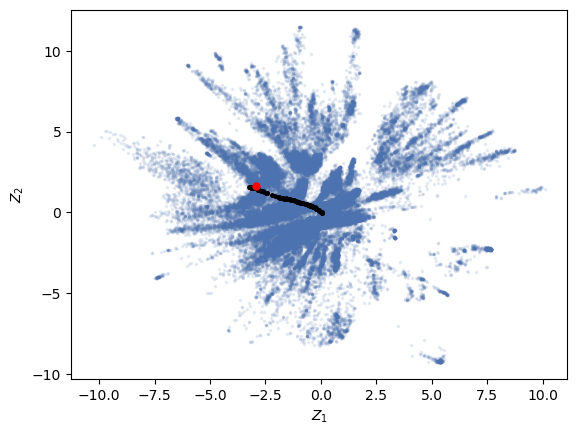

In [316]:
fig_lat, ax = plt.subplots(1, 1)

ax.plot(msa_embeddings[:, 0], msa_embeddings[:, 1], '.', alpha=0.1, markersize=3, )


# Project 
for seq_id, seq in ancestors.items():
    seq = ''.join(seq)
    seq_mu = latent_space.encode(seq)[0][0]
    ax.plot(seq_mu[0], seq_mu[1], '.', color='black', alpha=1, markersize=5,
            label='({})'.format(seq_id))
    
    #ax.annotate(str(seq_id), (seq_mu[0], seq_mu[1]))
ax.plot(query_coords[0], query_coords[1], '.', color='red', markersize=10)
ax.set_xlabel("$Z_1$")
ax.set_ylabel("$Z_2$")
fig_lat.savefig(os.path.join(run.results, "latent_space_with_anc.png"))

### Sequence Projection
Projecting custom sequence to latent space

In [320]:
run.pickles

'../results/pfam201_hmm/pickles'

In [323]:
with open(run.pickles+ "/msa_columns.pkl", "rb") as input_file:
   msa_columns = pickle.load(input_file)

In [382]:
with open(run.pickles+ "/msa_profile.pkl", "rb") as input_file:
   msa_profile = pickle.load(input_file)

In [388]:
import subprocess
subprocess.run("source ~/.zshrc", shell=True, executable="/bin/zsh")
hmmer_path = '/Users/dahala/Projects/HMMER/bin' #the path to the hmmer bin folder
out_path = '/Users/dahala/GitHub/VAE-enzymes/vae_notebooks/results/pfam201_hmm' #the path to the output folder
#subprocess.run(f'{hmmer_path}/hmmbuild --amino --symfrac 0 {out_path}/hmm/model.hmm {out_path}/msa/training_msa.fasta > {out_path}/hmm/hmmbuild.log', shell=True, executable="/bin/zsh") # had to create a new folder for hmm model
#subprocess.run(f'rm {out_path}/hmm/query.afa', shell=True, executable="/bin/zsh")
#for name in ['UGT71B1','Zm_UGT72G3','Mt_UGT71G1']:
#    subprocess.run(f'{hmmer_path}/hmmalign --trim --outformat afa {out_path}/hmm/model.hmm ../datasets/{name}.fasta >> {out_path}/hmm/query.afa', shell=True, executable="/bin/zsh") #not sure if the hmm folder the correct place to store the hmmalign output
subprocess.run(f'{hmmer_path}/hmmalign --trim --outformat afa {out_path}/hmm/model.hmm ../datasets/KnownGT1.faa > {out_path}/hmm/KnownGT1.afa', shell=True, executable="/bin/zsh") #not sure if the hmm folder the correct place to store the hmmalign output

CompletedProcess(args='/Users/dahala/Projects/HMMER/bin/hmmalign --trim --outformat afa /Users/dahala/GitHub/VAE-enzymes/vae_notebooks/results/pfam201_hmm/hmm/model.hmm ../datasets/KnownGT1.faa > /Users/dahala/GitHub/VAE-enzymes/vae_notebooks/results/pfam201_hmm/hmm/KnownGT1.afa', returncode=0)

In [355]:
# Function for fixing lower case and dots in the sequence
def fix_seqs(input_string):
    seq_ = input_string.replace('.', '')
    seq_ = ''.join([char for char in seq_ if not char.islower()])
    return seq_

def gaplimiter(seq,threshold=0.7):
    gap_percent = seq.count('-') / len(seq)
    if gap_percent > threshold:
        return False
    else:
        return True
    
def gaplimiter_df(df,threshold=0.7):
    return df[df['afa'].apply(lambda x: gaplimiter(x,threshold))]

def apply_msa_mask(msa_df, msa_columns):
    msa_df['trimmed_afa'] = msa_df['afa'].apply(lambda x: ''.join([x[i] for i in msa_columns]))
    return msa_df


In [391]:
from Bio import SeqIO
query_dict = {seq.description: fix_seqs(str(seq.seq)) for seq in SeqIO.parse(f'{out_path}/hmm/query.afa', "fasta")}
query_df = pd.DataFrame.from_dict(query_dict, orient='index', columns=['afa'])
query_df = apply_msa_mask(query_df, msa_columns)
known_dict = {seq.description: fix_seqs(str(seq.seq)) for seq in SeqIO.parse(f'{out_path}/hmm/KnownGT1.afa', "fasta")}
known_df_ = pd.DataFrame.from_dict(known_dict, orient='index', columns=['afa'])
known_df_ = apply_msa_mask(known_df_, msa_columns)

In [390]:
UGT71B1_seq = '------------------------AKLLVASDNRLSVTLIVIPSRVSDDASSSVYTNSEDRLRYILLPARDQTTDLVSYIDSQKPQVRAVVSKVAGDVSTRSDSRLAGIVVDMFCTSMIDIADEFNLSAYIFYTSNASYLGLQFHVQSLYDEKELDVSEFKDTEMKFDVPTLTQPFPAKCLPSVMLNKKWFPYVLGRARSFRATKGILVNSVADMEPQALSFFSGGNGNTNIPPVYAVGPIMDLESSGDEEKRKEILH---WLKEPTKSVVFLCFGSMGG-FSEEQAREIAVALERSGHRFLWSLRRLPKGFLDRTVKIISWAPQVDVLNSPAIGAFVTHCGWNSILESLWFGVPMAAWPIYAEQQFNAFHMVDEGLAAEVKKEYVTADEIERGIKCAMEQDSKMRKRVMEMKDK------------'
UGT71B1_seq == query_df.trimmed_afa[0]

True

In [392]:
KnownUGT_df = pd.read_excel('../../UGT_names_excel.xlsx',index_col=2)
KnownUGT_df = KnownUGT_df.merge(known_df_, left_index=True, right_index=True)

In [394]:
KnownGT_colors = {}
okabe_ito_colors_ext = ['white','lightgray','#000000','#750000','#56B4E9','#E69F00','#009E73','#D55E00','#0072B2','#CC79A7','#F0E442','darkgray']
colors=okabe_ito_colors_ext[3:]+['darkgreen']+['#FF6865']
for i,phylum in enumerate(pd.unique(KnownUGT_df.Phylum)):
    KnownGT_colors[phylum] = colors[i]

In [395]:
KnownGT_colors

{'Angiosperms': '#750000',
 'Actinobacteria': '#56B4E9',
 'Chordata': '#E69F00',
 'Deinococcus-Thermus': '#009E73',
 'Cyanobacteria': '#D55E00',
 'Chlorophyta': '#0072B2',
 'Arthropoda': '#CC79A7'}

In [398]:
mu1_ = []
mu2_ = []
for seq in KnownUGT_df.trimmed_afa:
    seq_mu = latent_space.encode(seq)[0][0]
    mu1_.append(seq_mu[0])
    mu2_.append(seq_mu[1])
KnownUGT_df['mu1'] = mu1_
KnownUGT_df['mu2'] = mu2_

No handles with labels found to put in legend.


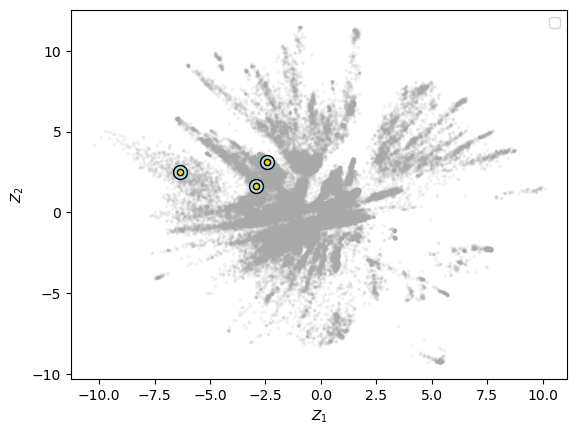

In [381]:
fig_lat, ax = plt.subplots(1, 1)

ax.plot(msa_embeddings[:, 0], msa_embeddings[:, 1], '.', alpha=0.1, markersize=3, zorder=1,color='darkgray')


# Project
for seq in query_df.trimmed_afa:
    seq_mu = latent_space.encode(seq)[0][0]
    ax.scatter(seq_mu[0], seq_mu[1], color='lightblue', alpha=1, s=100, zorder=2,edgecolor='black')

#ax.scatter(seq_mu[0], seq_mu[1], color='green', alpha=1, s=100,edgecolor='black', zorder=2)
    
    #ax.annotate(str(seq_id), (seq_mu[0], seq_mu[1]))
ax.scatter(query_coords[0::2], query_coords[1::2], color='gold', alpha=1, s=20,edgecolor='black', zorder=5)
ax.set_xlabel("$Z_1$")
ax.set_ylabel("$Z_2$")
ax.legend(fontsize=10)
fig_lat.savefig(os.path.join(run.results, "latent_space_with_custom_seq.png"))

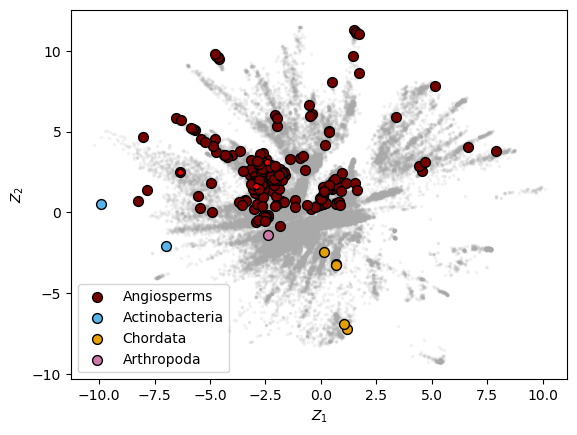

In [401]:
fig_lat, ax = plt.subplots(1, 1)

ax.plot(msa_embeddings[:, 0], msa_embeddings[:, 1], '.', alpha=0.1, markersize=3, zorder=1,color='darkgray')


# Project
for phylum in pd.unique(KnownUGT_df.Phylum):
    df_ = gaplimiter_df(KnownUGT_df[KnownUGT_df.Phylum == phylum])
    if df_.shape[0] == 0:
        continue
    mu1_ = df_.mu1
    mu2_ = df_.mu2
    ax.scatter(mu1_, mu2_, color=KnownGT_colors[phylum], alpha=1, s=50,edgecolor='black', zorder=2, label = phylum)
    #ax.annotate(str(seq_id), (seq_mu[0], seq_mu[1]))
ax.scatter(query_coords[0::2], query_coords[1::2], color='red', alpha=1, s=20,edgecolor='black', zorder=2)
ax.set_xlabel("$Z_1$")
ax.set_ylabel("$Z_2$")
ax.legend(fontsize=10)
fig_lat.savefig(os.path.join(run.results, "latent_space_with_knownGT1_seq.png"))

In [294]:
run.fixed_sequences

['U71B1_ARATH/231-422', 'B6SRY5_MAIZE/245-452', 'Q5IFH7_MEDTR/244-441']

In [303]:
for query_msa,query_hmm in zip(run.fixed_sequences,['UGT71B1','Zm_UGT72G3','Mt_UGT71G1']):
    print(query_msa, latent_space.key_to_embedding(query_msa))
    print(query_hmm, KnownUGT_df.loc[query_hmm][['mu1','mu2']].to_numpy())


U71B1_ARATH/231-422 [0.17568812 2.6969595 ]
UGT71B1 [tensor(1.2276) tensor(5.3119)]
B6SRY5_MAIZE/245-452 [3.97243524 4.74606657]
Zm_UGT72G3 [tensor(3.0045) tensor(3.6711)]
Q5IFH7_MEDTR/244-441 [0.88905472 3.57490516]
Mt_UGT71G1 [tensor(0.7185) tensor(2.8470)]
